In [ ]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Mounted at /content/drive
GPU Available:  False


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [ ]:
train_dir = '/content/drive/MyDrive/DatasetSplit80/train'
val_dir = '/content/drive/MyDrive/DatasetSplit80/validation'
test_dir = '/content/drive/MyDrive/DatasetSplit80/test'

In [ ]:
categories = ["Bayam Gagal Panen", "Selada Gagal Panen", "Pakcoy Gagal Panen",
              "Bayam Siap Panen", "Selada Siap Panen", "Pakcoy Siap Panen"]

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


num_classes = len(categories)
image_size = (224, 224)
batch_size = 32


train_datagen = ImageDataGenerator(
    # rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
    )

val_datagen = ImageDataGenerator(
    # rescale=1./255
    )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

# Test Generator
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Membuat model MobileNet (ditambah channel RGB, karena gambar sebelumnya grayscale)
base_model = MobileNet(input_shape=image_size + (3,), include_top=False, weights='imagenet')

# Menambahkan lapisan global pooling dan lapisan output
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Menggabungkan model
model = Model(inputs=base_model.input, outputs=predictions)

# Membekukan lapisan awal (pretrained) agar tidak terupdate saat melatih model (transfer learning)
for layer in base_model.layers:
    layer.trainable = False

Found 789 images belonging to 6 classes.
Found 129 images belonging to 6 classes.
Found 134 images belonging to 6 classes.
17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
# Buat objek callback EarlyStopping

epochs = 20
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size
# lr = default


early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# Mengkompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop])

Epoch 1/20
24/24 [==============================] - 197s 8s/step - loss: 1.6366 - accuracy: 0.3567 - val_loss: 1.2024 - val_accuracy: 0.5234
Epoch 2/20
24/24 [==============================] - 51s 2s/step - loss: 1.0340 - accuracy: 0.6103 - val_loss: 0.9868 - val_accuracy: 0.6250
Epoch 3/20
24/24 [==============================] - 51s 2s/step - loss: 0.8149 - accuracy: 0.7107 - val_loss: 0.7733 - val_accuracy: 0.7422
Epoch 4/20
24/24 [==============================] - 50s 2s/step - loss: 0.7018 - accuracy: 0.7701 - val_loss: 0.7050 - val_accuracy: 0.8047
Epoch 5/20
24/24 [==============================] - 53s 2s/step - loss: 0.6354 - accuracy: 0.7873 - val_loss: 0.6567 - val_accuracy: 0.7812
Epoch 6/20
24/24 [==============================] - 55s 2s/step - loss: 0.5050 - accuracy: 0.8283 - val_loss: 0.4905 - val_accuracy: 0.8359
Epoch 7/20
24/24 [==============================] - 49s 2s/step - loss: 0.4520 - accuracy: 0.8613 - val_loss: 0.4750 - val_accuracy: 0.8438
Epoch 8/20
24/24 [=

In [ ]:
model.evaluate(test_generator)

5/5 [==============================] - 25s 6s/step - loss: 0.1538 - accuracy: 0.9701


[0.15384939312934875, 0.9701492786407471]

5/5 [==============================] - 9s 2s/step
                    precision    recall  f1-score   support

 Bayam Gagal Panen    0.96154   1.00000   0.98039        25
Selada Gagal Panen    0.96667   1.00000   0.98305        29
Pakcoy Gagal Panen    1.00000   0.95000   0.97436        20
  Bayam Siap Panen    1.00000   0.93333   0.96552        15
 Selada Siap Panen    0.93548   1.00000   0.96667        29
 Pakcoy Siap Panen    1.00000   0.87500   0.93333        16

          accuracy                        0.97015       134
         macro avg    0.97728   0.95972   0.96722       134
      weighted avg    0.97165   0.97015   0.96981       134

[[25  0  0  0  0  0]
 [ 0 29  0  0  0  0]
 [ 0  0 19  0  1  0]
 [ 1  0  0 14  0  0]
 [ 0  0  0  0 29  0]
 [ 0  1  0  0  1 14]]
1/1 [==============================] - 2s 2s/step


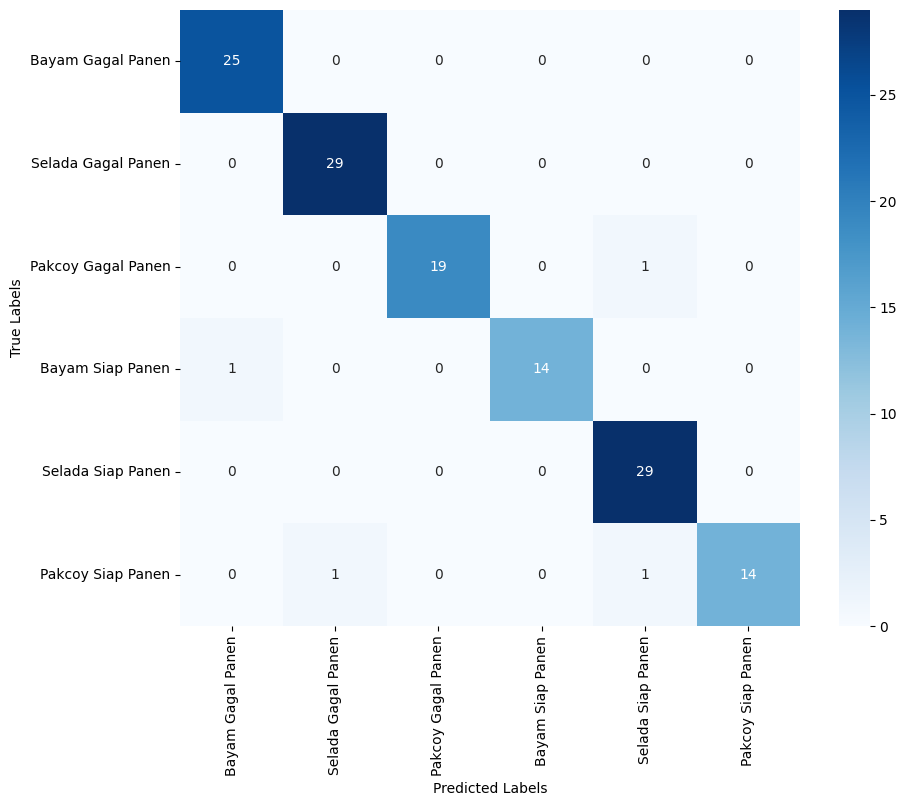

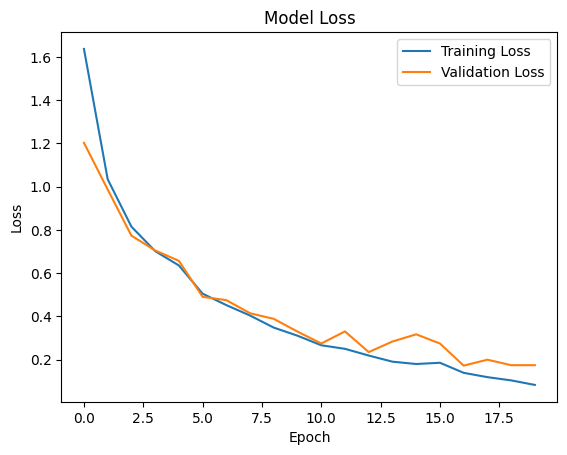

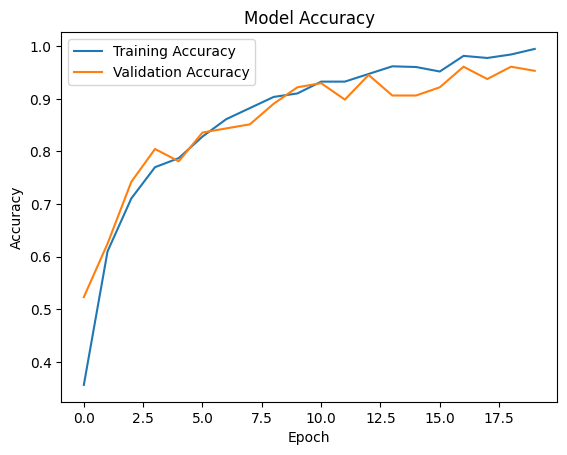

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


# Prediksi data test
y_pred = model.predict(test_generator)

# Prediksi berdasaarkan class/label
y_pred_labels = np.argmax(y_pred, axis=1)
class_names = ["Bayam Gagal Panen", "Selada Gagal Panen", "Pakcoy Gagal Panen",
              "Bayam Siap Panen", "Selada Siap Panen", "Pakcoy Siap Panen"]

# get true labels from the generator
y_true = test_generator.classes

# Confusion Matrix
report = classification_report(y_true, y_pred_labels, target_names=class_names, digits=5)
conf_mat = confusion_matrix(y_true, y_pred_labels)

print(report)
print(conf_mat)

# Load batch data
batch_images, batch_labels = next(test_generator)

# Normalisasi kembali gambar ke rentang 0-255
batch_images = (batch_images * 255).astype(np.uint8)

# Predict labels/class dengan model
predicted_labels = model.predict(batch_images)

# Daftar class
class_names = list(train_generator.class_indices.keys())

# Membuat plot
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g',
            xticklabels=["Bayam Gagal Panen", "Selada Gagal Panen", "Pakcoy Gagal Panen",
              "Bayam Siap Panen", "Selada Siap Panen", "Pakcoy Siap Panen"],
            yticklabels=["Bayam Gagal Panen", "Selada Gagal Panen", "Pakcoy Gagal Panen",
              "Bayam Siap Panen", "Selada Siap Panen", "Pakcoy Siap Panen"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Mengambil nilai loss dan akurasi dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Membuat grafik loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Membuat grafik akurasi
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/HYDOGROW_MobileNet_80_Adam_model.pb')